In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import re
import torch.nn.functional as F
from torch import optim
from torchvision.io import read_image
from torch.utils.data import TensorDataset
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
writer = SummaryWriter()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([  # трансформации изображений
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
class TrainSet(Dataset):
    """
    Class containing train dataset
    """
    def __init__(self, dir):
        """
        Trainset class constructor
        :param dir: path to trainset directory
        """
        self.train_dir = Path(dir)
        self.train_files_path = sorted(list(self.train_dir.rglob('*.jpg')))  # пути к файлам трейна
        self.train_class_names = [path.parent.name for path in self.train_files_path]  # имена классов для файлов трейна

        class_paths = sorted(list(self.train_dir.glob('*')))
        classes = [path.name for path in class_paths]  # список имен классов
        self.class_id = {classes[i]: i for i in range(len(classes))}  # словарик с класс айди

    def __len__(self):
        """
        get length of trainset
        :return: length
        """
        return len(self.train_files_path)

    def __getitem__(self, index):
        """
        get single item
        :param index:
        :return:
        """
        img = read_image(str(self.train_files_path[index]))
        img = img / 255.0
        img = transform(img)

        name = self.train_class_names[index]
        img_y = self.class_id[name]

        return img, img_y


class ValSet(Dataset):
    """
    Chunga changa
    """

    def __init__(self, dir1, dir2):
        """
        ValSet class constructor
        :param dir: path to trainset directory
        """
        self.train_dir = Path(dir1)
        self.test_dir = Path(dir2)
        self.test_files_path = sorted(list(self.test_dir.rglob('*.jpg')))  # пути к файлам теста
        test_classes = [path.name for path in self.test_files_path]
        self.test_class_names = [re.sub(r"_\d+.jpg", "", path) for path in test_classes]  # имена классов для теста

        class_paths = sorted(list(self.train_dir.glob('*')))
        classes = [path.name for path in class_paths]  # список имен классов
        self.class_id = {classes[i]: i for i in range(len(classes))}  # словарик с класс айди

    def __len__(self):
        """
        get length of set
        :return: length
        """
        return len(self.test_files_path)

    def __getitem__(self, index):
        """
        get single item
        :param index:
        :return:
        """
        img = read_image(str(self.test_files_path[index]))
        img = img / 255.0
        img = transform(img)

        name = self.test_class_names[index]
        img_y = self.class_id[name]

        return img, img_y

In [4]:
train_ds = TrainSet("simpsons_dataset/simpsons_dataset")
val_ds = ValSet("simpsons_dataset/simpsons_dataset", "kaggle_simpson_testset")

In [5]:
print(torch.cuda.is_available())  # проверим доступны ли вычисления на gpu

True


In [6]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")  # cuda - графический процессор, cpu - центральный


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


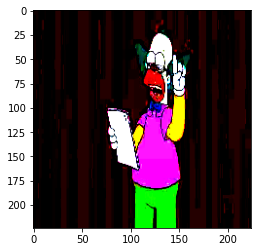

In [9]:
img, label = train_ds[10000]
img = img.permute(1,2,0)
plt.imshow(img) ## это всё чтобы картинку чекнуть 


In [10]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)  # создаём даталоадер
val_dl = DataLoader(val_ds, batch_size=128)

In [11]:
not_le_net = models.resnet18(pretrained=True)  # загружаем предобученную модель
# print(not_le_net)

for param in not_le_net.parameters():
    param.requires_grad = False

not_le_net.fc = nn.Sequential(nn.Linear(512, 256),  # подгоняем архитектуру под нужное количество классов
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 42),
                                 nn.LogSoftmax(dim=1))

not_le_net.to(dev)  # отправляем на девайс
loss_func = F.cross_entropy  # функция оштбки - кросс энтропия
opt = optim.SGD(not_le_net.parameters(), lr=0.001, momentum=0.9)  # способ оптимизации - стохастический градиентный спуск с моментумом


In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    predict = model(xb)  # прямой проход
    loss = loss_func(predict, yb)  # подсчёт функции ошибки
    predict = [torch.argmax(pred) for pred  in predict]
    predict = torch.stack(predict, 0)
    trueCount = 0
    for i in range(len(yb)):
        if predict[i] == yb[i]:
            trueCount += 1  # подсчёт количества верно угаданных сэмплов
    
    if opt is not None:  # приобучении opt указывается, при валидации он не нужен, т.к. веса мы уже не меняем
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), trueCount / len(yb)

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        _, numsT, acc_train = zip(*[loss_batch(model, loss_func, xb.cuda(), yb.cuda(), opt) for xb, yb in train_dl])

        model.eval()
        with torch.no_grad():
            losses, nums, acc_val = zip(
                *[loss_batch(model, loss_func, xb.cuda(), yb.cuda()) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
#         accuracy_train = np.mean(acc_train)
#         accuracy_val = np.mean(acc_val)
        accuracy_val = np.sum(np.multiply(acc_val, nums)) / np.sum(nums)
        accuracy_train = np.sum(np.multiply(acc_train, numsT)) / np.sum(numsT)

        writer.add_scalar("Acc_Val", accuracy_val, epoch)
        print(epoch, val_loss, accuracy_train, accuracy_val)

In [ ]:
epochs = 40
fit(epochs, not_le_net, loss_func, opt, train_dl, val_dl)
writer.flush()
writer.close()
torch.save(not_le_net.state_dict(), 'lenet10_04.pth')

0 2.782047159021551 0.19476424783834137 0.296969696969697
1 2.192565930250919 0.4467587063488272 0.4818181818181818
2 1.8089939483488449 0.5585439258586921 0.5363636363636364
